<a href="https://colab.research.google.com/github/ZabalaGaston/HPC/blob/main/Zabala_Gaston_ejercicio_2_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Introducción

El siguiente ejemplo modifica el color de una imágen parametrizada, a escala de grises. El cálculo de la escala se realiza convirtiendo los 3 canales RGB, que representan a los colores R (*rojo*)-G(*verde*)-B(*azul*), de cada pixel siguiendo la ecuación:

<center>$ Pixel=R*0.30+G*0.59+B*0.11$</center>

EL objetivo es enseñar el funcionamiento del Lenguaje Python, CUDA y el manejo de imagenes a bajo nivel. El ejemplo es ilustrativo, ya que internamente el módulo Pillow posee varios filtros integrados.

---
# 2 Armado del ambiente
Toma la direcciòn web de una imagen con  acceso público en internet, la deja disponible al contexto de ejecuciòn del cuaderno colab.

In [1]:
#@title # 2.1 Parámetros de ejecución
#@markdown ---
#@markdown ### Especifique la URL de la imagen:
url_imagen = "https://www.dzoom.org.es/wp-content/uploads/2017/07/seebensee-2384369-1024x681.jpg" #@param {type:"string"}
!wget {url_imagen} -O imagen.jpg



--2020-11-17 14:18:12--  https://www.dzoom.org.es/wp-content/uploads/2017/07/seebensee-2384369-1024x681.jpg
Resolving www.dzoom.org.es (www.dzoom.org.es)... 172.67.73.36, 104.26.11.161, 104.26.10.161, ...
Connecting to www.dzoom.org.es (www.dzoom.org.es)|172.67.73.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 239427 (234K) [image/jpeg]
Saving to: ‘imagen.jpg’

imagen.jpg          100%[===================>] 233.82K  --.-KB/s    in 0.05s   

2020-11-17 14:18:12 (5.06 MB/s) - ‘imagen.jpg’ saved [239427/239427]



---
## 2.2 Instala en el cuaderno el módulo CUDA de Python.

In [3]:
!pip install pycuda

     |████████████████████████████████| 1.6MB 11.1MB/s 
     |████████████████████████████████| 71kB 8.0MB/s 
     |████████████████████████████████| 81kB 8.4MB/s 
  Created wheel for pycuda: filename=pycuda-2020.1-cp36-cp36m-linux_x86_64.whl size=620990 sha256=f30d8988755c64cd20e89d4047534c38cbb18d82c72ffdd00fb7889b461ebe30
  Stored in directory: /root/.cache/pip/wheels/8f/78/d1/5bb826f81d9d490297a348d818ff3ee6dd6f2075b06dde6ea0
  Created wheel for pytools: filename=pytools-2020.4.3-py2.py3-none-any.whl size=61374 sha256=67cc41c06695ecddf347687c7a56d8bb6513eb46df3bfc28d28052f1b06dabd2
  Stored in directory: /root/.cache/pip/wheels/af/c7/81/a22edb90b0b09a880468b2253bb1df8e9f503337ee15432c64
Successfully built pycuda pytools


---
# 3 Desarrollo
Ejecución del algoritmo escala de grises en GPU.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(8): warning: variable "fGris" was declared but never referenced




Imagen del filtro: imagen.jpg -RGB- [681, 1024]
Thread: [ 16 , 19  ], Bloque : [ 43 , 54 ]
Total de Thread: [ 688 , 1026  ]  =  705888
Tiempo TOTAL:  397.272 [ms]
Tiempo GPU  :  0.324 [ms]


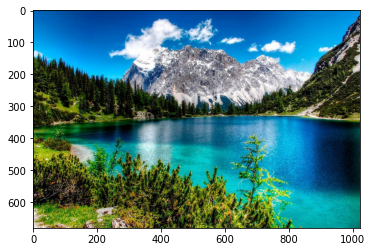

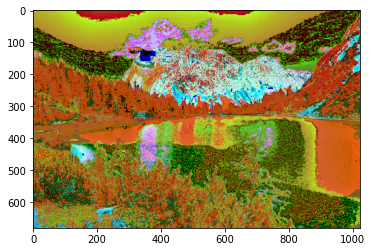

In [32]:
%matplotlib inline
from datetime import datetime
tiempo_total = datetime.now()

import matplotlib.pyplot as plt
import numpy
from PIL import Image 
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------

img_nombre = 'imagen.jpg'
image = Image.open( img_nombre ) 
  
# summarize some details about the image 
img_alto, img_ancho = image.size 

# Convierto la imagen comprimida en JPEG/PNG a array
img_O_cpu = numpy.asarray(image)
img_R_cpu = numpy.empty_like( img_O_cpu)

# Reservo los 2 vectores en GPU(3 pixeles usa RGB * (el tamaño del array))
img_O_gpu = cuda.mem_alloc( img_O_cpu.nbytes )
img_R_gpu = cuda.mem_alloc( img_R_cpu.nbytes )

# GPU - Copio la memoria al GPU.
cuda.memcpy_htod( img_O_gpu, img_O_cpu )
cuda.memcpy_htod( img_R_gpu, img_R_cpu )

# CPU - Defino la función kernel que ejecutará en GPU.
module = SourceModule("""
__global__ void kernel_img( int ancho, int alto, char *img_O, char *img_R )
{
  // Calculo las coordenadas del Thread en dos dimensiones.
  int idx = threadIdx.x + blockIdx.x*blockDim.x;
  int idy = threadIdx.y + blockIdx.y*blockDim.y;
  float fGris = 0.0;
  float r, g, b, min, max, diferencia,h,s,v;
  float vector[3];
  int i;


  // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
  if( idx < ancho && idy < alto )
  {

    r = (float)img_O[(idx+(idy*ancho))*3] / 255.0;
    g = (float)img_O[((idx+(idy*ancho))*3)+1] / 255.0;
    b = (float)img_O[((idx+(idy*ancho))*3)+2] / 255.0;
    vector [0] = r; 
    vector [1] = g;
    vector [2] = b;

    min = vector [0];
    max = vector [0];

    for (i = 1; i < 3; i++) 
    {
      if (vector[i] < min) 
	      min = vector[i];
      
      if (vector[i] > max) 
	      max = vector[i];
    }   
   
    diferencia = max - min;

    if (min == max)
      h = 0;
    else if (max == r)
      h = int(60 *((g - b)/diferencia) + 360)% 360;
    else if (max == g)
      h = int(60 * ((g - b)/diferencia) + 120 ) % 360;
    else if (max == b)
      h = int(60 * ((g - b)/diferencia) + 240) % 360;

    if (max == 0)
      s = 0;
    else
      s = (diferencia / max) * 100;

    v = max * 100;

    // Calculo el color gris para el pixel a partir de los componentes.
    //fGris = (float)img_O[(idx+(idy*ancho))*3    ]*0.299;  // Componente Rojo del pixel.
    //fGris +=(float)img_O[((idx+(idy*ancho))*3)+1]*0.599;  // Componente Verde del pixel.
    //fGris +=(float)img_O[((idx+(idy*ancho))*3)+2]*0.11;   // Componente Azul del pixel.
    // Escribo el color del pixel.
    img_R[(idx+(idy*ancho))*3  ] = (char) h;
    img_R[(idx+(idy*ancho))*3+1] = (char) s;
    img_R[(idx+(idy*ancho))*3+2] = (char) v;
  }
}
""") 

# Muestro los atributos de la imagen y como se ve antes del seudo filtro.
print("Imagen del filtro: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

# CPU - Genero la función kernel.
kernel = module.get_function("kernel_img")

tiempo_img = datetime.now()

dim_hilo_x = 16
dim_bloque_x = numpy.int( (img_ancho+dim_hilo_x-1) / dim_hilo_x )

dim_hilo_y = 19
dim_bloque_y = numpy.int( (img_alto+dim_hilo_y-1) / dim_hilo_y )

print( "Thread: [", dim_hilo_x, ",", dim_hilo_y, " ], Bloque : [", dim_bloque_x, ",", dim_bloque_y, "]" )
print( "Total de Thread: [", dim_hilo_x*dim_bloque_x, ",", dim_hilo_y*dim_bloque_y, " ]", " = ", dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y )

tiempo_img = datetime.now()

kernel( numpy.int32(img_ancho), numpy.int32(img_alto), img_O_gpu, img_R_gpu, block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) )

tiempo_img = datetime.now() - tiempo_img

# GPU - Copio el resultado desde la memoria GPU.
cuda.memcpy_dtoh( img_R_cpu, img_R_gpu )

# Muestro la imagen Original el filtro.
plt.figure()
imgplot=plt.imshow( img_O_cpu )

# Muestro la imagen luego de aplicarle el filtro.
plt.figure()
imgplot=plt.imshow( img_R_cpu )

tiempo_total = datetime.now() - tiempo_total

print("Tiempo TOTAL: ", tiempo_en_ms( tiempo_total ), "[ms]" )
print("Tiempo GPU  : ", tiempo_en_ms( tiempo_img ), "[ms]" )


---
# 4 Tabla de pasos


 Procesador | Funciòn | Detalle
------------|---------|----------
CPU      |  wget url_imagen       | Lectura de la direcciòn URL de la imagen (jpg) a procesar.
CPU      | pip install pycuda    | Instala en el cuaderno los driver de CUDA para Python.
CPU      |  matplotlib inline    | Macro de Colab para mostrar imagenes.
CPU      |  import                | Importa los módulos para funcionar.
CPU      |  datetime.now()        | Toma el tiempo actual.
CPU      |  Image.open()          | Abre el archivo de la imagen.
CPU      |  numpy.asarray(imagen) | Convierte el formato comprimido JPG a RAW.
CPU      |  numpy.empty_like(()   | Genera el array destino, que tendrá a la imagen resultado. 
**GPU**  |  cuda.mem_alloc()      | Reserva la memoria para las imagenes en GPU.
**GPU**  |  cuda.memcpy_htod()    | Copio los valores en crudo de las imagenes al GPU.
CPU      |  SourceModule()        | Posee el còdigo del kernel.
CPU      |  module.get_function() | convierte el texto del kernel en funcion de Python.
CPU      |  dim_hilo_x, dim_hilo_y| Calcula las dimensiones para la ejecuciòn de 2D.
**GPU**  |  kernel()              | Ejecuta el kernel en GPU, enviando los parametros.
CPU      |  print()               | Informa los atributos de la imagen.
CPU      | cuda.memcpy_dtoh()     | Copia desde la memoria GPU al CPU.
CPU      |  plt.imshow            | Muestra la imagen original.
CPU      |  plt.imshow            | Muestra la imagen resultado.



---
# 5 Conclusiones

Las conclusiones son explicadas en clase...

---
# 6 Bibliografía

[1] MARKDOWN SYNTAX Colab: [PDF](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/markdown-cheatsheet-online.pdf)

[2] Introducción a Python: [Página Colab](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/Python_Basico.ipynb) 

[3] Tutorial Point Colab: [PDF](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/markdown-cheatsheet-online.pdf)

[4] 2009, SINTESIS DIGITAL DE COLOR UTILIZANDO TONOS DE GRIS, ING. JESÚS GUSTAVO FLORES ERAÑA : [PDF](https://ninive.uaslp.mx/xmlui/bitstream/handle/i/2264/MCA1SDC00901.pdf?sequence=1&isAllowed=y)
